# 0. Imports

### 0.1 Libs

In [1]:
import re
import warnings
import inflection
import sqlite3


import numpy            as np
import pandas           as pd
import seaborn          as sns
import umap.umap_       as umap
import matplotlib.cm    as cm
import scipy.stats      as st

from IPython.display        import Image
from sqlalchemy             import create_engine
from pandas_profiling       import ProfileReport

from plotly                 import express          as px
from matplotlib             import pyplot           as plt

from scipy                  import stats            as ss
from scipy.cluster          import hierarchy        as hc

from sklearn                import cluster          as c
from sklearn                import metrics          as m
from sklearn                import preprocessing    as pp
from sklearn                import decomposition    as dd
from sklearn                import ensemble         as en
from sklearn                import mixture          as mx
from sklearn                import manifold         as mn

/home/vitor/.pyenv/versions/3.9.0/envs/LoyaltyProgram/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 0.2 Helper Functions

In [2]:
warnings.simplefilter("ignore")

def numerical_metrics(numerical_attributes):
    #ct = central tendency
    ct_mean = pd.DataFrame(numerical_attributes.apply(np.mean)).T
    ct_median = pd.DataFrame(numerical_attributes.apply(np.median)).T

    #d = dispersion
    d_std = pd.DataFrame(numerical_attributes.apply(np.std)).T
    d_min = pd.DataFrame(numerical_attributes.apply(min)).T
    d_max = pd.DataFrame(numerical_attributes.apply(max)).T
    d_range = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
    d_skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
    d_kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

    concat = pd.concat([d_min,d_max,d_range,ct_mean,ct_median,d_std,d_skew,d_kurtosis]).T.reset_index()
    concat.columns=['Attributes','Min','Max','Range','Mean','Median','STD','Skew','Kurtosis']

    return concat

### 0.3 Loading Data

In [3]:
df_raw = pd.read_csv('../data/data.csv', encoding= 'unicode_escape')

# 1. Data Description

### 1.0 Rename Columns

In [4]:
df1 = df_raw.copy()

df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [5]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map(snakecase, cols_old))

df1.columns = cols_new

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### 1.1 Data Dimentions

In [6]:
print(f'Number of Rows:{df1.shape[0]}')
print(f'Number of Columns:{df1.shape[1]}')
print('Number of Clients:{}'.format(len(df1['customer_id'].unique())))

Number of Rows:541909
Number of Columns:8
Number of Clients:4373


In [7]:
print('First day: {}'.format(df1['invoice_date'].min()))
print('Last day: {}'.format(df1['invoice_date'].max()))

First day: 1/10/2011 10:04
Last day: 9/9/2011 9:52


### 1.2 Data Types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

### 1.3 Check NA

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### 1.4 Fillout NA

In [10]:
df1 = df1.dropna(subset=['description', 'customer_id'])
print('Removed data: {:.0%}'.format( 1-(df1.shape[0] / df_raw.shape[0])))
print(f'New number of rows: {df1.shape[0]}')

Removed data: 25%
New number of rows: 406829


In [11]:
# # Tentativa: criar um id para os valores faltantes e assim não descartar as informações registradas

# df_missing = df1.loc[df1['customer_id'].isna(), :]
# df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

# # create reference
# df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
# df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)


# # Merge with original dataframe
# df1 = pd.merge(df1, df_backup, on = 'invoice_no', how = 'left')

# # **Coalesce
# df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# # drop extra columns
# df1 = df1.drop(columns = ['customer_id_x', 'customer_id_y'], axis=1)

# df1.head()

In [12]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

### 1.5 Change Types

In [13]:
df1['customer_id'] = df1['customer_id'].astype(int)

df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])
df1['invoice_date'] = df1['invoice_date'].dt.strftime('%Y-%m-%d')
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850,United Kingdom


In [14]:
print('First day: {}'.format(df1['invoice_date'].min()))
print('Last day: {}'.format(df1['invoice_date'].max()))

First day: 2010-12-01 00:00:00
Last day: 2011-12-09 00:00:00


### 1.6 Descriptive Statistics

#### 1.6.0  Datasets

In [15]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

#### 1.6.1 Nummerical Attributes

In [16]:
numerical_metrics(num_attributes)

,Attributes,Min,Max,Range,Mean,Median,STD,Skew,Kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


#### 1.6.2 Categorical Attributes

##### Overview

In [17]:
cat_attributes.sample(3).T

,334782,286594,456388
invoice_no,566269,562031,575688
stock_code,22024,21524,21175
description,RAINY LADIES BIRTHDAY CARD,DOORMAT SPOTTY HOME SWEET HOME,GIN + TONIC DIET METAL SIGN
country,United Kingdom,United Kingdom,United Kingdom


In [18]:
cat_attributes.describe()

,invoice_no,stock_code,description,country
count,406829,406829,406829,406829
unique,22190,3684,3896,37
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,542,2077,2070,361878


##### Invoice No

In [19]:
# Quantidade de registros com letras
df_letter_invoice = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]
print(f'Total invoice_no with letter: {len(df_letter_invoice)}')
print('Total invoice_no with letter and negative quantity value: {}'.format(len(df_letter_invoice[df_letter_invoice['quantity']<0])))

df_letter_invoice

Total invoice_no with letter: 8905
Total invoice_no with letter and negative quantity value: 8905


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
141,C536379,D,Discount,-1,2010-12-01,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09,0.83,14397,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09,224.69,15498,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09,10.95,15311,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09,1.25,17315,United Kingdom


##### Stock Code

In [20]:
# The stock_code should be a number
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), :]
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

# task: remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

##### Description

In [21]:
# Task: delete description

##### Country

In [22]:
len(df1['country'].unique())

37

In [23]:
df1['country'].value_counts(normalize = True).head()

United Kingdom    0.889509
Germany           0.023339
France            0.020871
EIRE              0.018398
Spain             0.006226
Name: country, dtype: float64

In [24]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head()

,country,customer_id
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25


# 2. Data Filtering 

### 2.1 Bad Users

In [25]:
df2 = df1.copy()

In [26]:
df2 = df2[~df2['customer_id'].isin([16446])]  # Maior número de devolução do conjunto de dados
df2 = df2[~df2['customer_id'].isin([17548, 16546, 15823, 13672, 12346, 13762, 18268, 14557, 16878, 13364, 14792, 12607, 12454, 18274, 12558])]  # itens devolvidos >= itens comprados



### 2.2 Cat Attributes

In [27]:
# Stock Code != ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']
# df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'])]

# Description
df2 = df2.drop(columns = 'description', axis = 1)

### 2.3 Num Attributes

In [28]:
# Unit Price > 0.04 
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# Quantity
df_returns = df2.loc[df2['quantity']<0, :]
df_purchases = df2.loc[df2['quantity']>0, :]

# 3. Feature Engineering

### 3.0 Dataset

In [29]:
df3 = df2.copy()

# Data Reference
df_ref = df3.drop (['invoice_no', 'stock_code',
                    'quantity', 'invoice_date', 'unit_price',
                    'country'], axis=1).drop_duplicates(ignore_index=True)

### 3.1 Gross Revenue

In [30]:
# Monetary (Gross Revenue)
df_purchases['gross_revenue'] = df_purchases['quantity'] * df_purchases['unit_price']
df_monetary = df_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge (df_ref, df_monetary, on = 'customer_id', how = 'left')

df_ref.isna().sum()

customer_id       0
gross_revenue    27
dtype: int64

### 3.2 Recency - Day from last purchase

In [31]:
# Recency
df_recency = df_purchases[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df_purchases['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on = 'customer_id', how = 'left')

df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
dtype: int64

### 3.3 Quantity of purchases

In [32]:
df_count = (df_purchases[['customer_id', 'invoice_no']].drop_duplicates()
                                                       .groupby('customer_id')
                                                       .count()
                                                       .reset_index()
                                                       .rename(columns={'invoice_no':'purchases_no'}))

df_ref = pd.merge(df_ref, df_count, on = 'customer_id', how = 'left')

### 3.4 Quantity of diferent products purchased

In [33]:
df_prod = (df_purchases[['customer_id', 'stock_code']].groupby('customer_id')
                                                      .count()
                                                      .reset_index()
                                                      .rename(columns={'stock_code':'products_no'}))

df_ref = pd.merge(df_ref, df_prod, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
purchases_no     27
products_no      27
dtype: int64

### 3.5 Quantity of items purchased


In [34]:
df_prod = (df_purchases[['customer_id', 'quantity']].groupby('customer_id')
                                                    .sum()
                                                    .reset_index()
                                                    .rename(columns={'quantity':'items_no'}))

df_ref = pd.merge(df_ref, df_prod, on = 'customer_id', how = 'left')
df_ref.isna().sum()


customer_id       0
gross_revenue    27
recency_days     27
purchases_no     27
products_no      27
items_no         27
dtype: int64

### 3.6 Frequency Purchase

In [35]:
df_aux = (df_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                                     .groupby('customer_id')
                                                                     .agg(max_    = ('invoice_date', 'max'),
                                                                          min_    = ('invoice_date', 'min'),
                                                                          days_   = ('invoice_date', lambda x: ((x.max() - x.min()).days) + 1),
                                                                          buy_    = ('invoice_no', 'count') ) ).reset_index()

df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis = 1)

# Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
purchases_no     27
products_no      27
items_no         27
frequency        27
dtype: int64

### 3.7 Returns

In [36]:
df_returns.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country
154,C536383,35004C,-1,2010-12-01,4.65,15311,United Kingdom
939,C536506,22960,-6,2010-12-01,4.25,17897,United Kingdom
1441,C536543,22632,-1,2010-12-01,2.10,17841,United Kingdom
1442,C536543,22355,-2,2010-12-01,0.85,17841,United Kingdom
1973,C536548,22244,-4,2010-12-01,1.95,12472,Germany


In [37]:
# Return Number
df_returns = df_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity' : 'returns_no'})
df_returns['returns_no'] = df_returns['returns_no'] * -1

df_ref = pd.merge(df_ref, df_returns, how = 'left', on='customer_id')
df_ref.loc[df_ref['returns_no'].isna(), 'returns_no'] = 0

df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
purchases_no     27
products_no      27
items_no         27
frequency        27
returns_no        0
dtype: int64

### 3.8 Satisfaction Rate

In [38]:
df_ref['satisfaction_rate'] = 1 - df_ref['returns_no'] / df_ref['items_no']

In [39]:
df_ref.isna().sum()

customer_id           0
gross_revenue        27
recency_days         27
purchases_no         27
products_no          27
items_no             27
frequency            27
returns_no            0
satisfaction_rate    27
dtype: int64

### 3.9 Recurrence

In [40]:
df_purchases['invoice_month'] = df_purchases['invoice_date'].dt.month
df_aux = df_purchases[['customer_id', 'invoice_month']].drop_duplicates().groupby(['customer_id']).count().reset_index()
df_aux = df_aux.rename(columns={'invoice_month':'recorrence'})

# Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'recorrence']], on = 'customer_id', how = 'left')
df_ref.isna().sum()

                                                                  

customer_id           0
gross_revenue        27
recency_days         27
purchases_no         27
products_no          27
items_no             27
frequency            27
returns_no            0
satisfaction_rate    27
recorrence           27
dtype: int64

# 4. Exploratory Data Analysis

### 4.1 Profile Report

In [41]:
df4 = df_ref.dropna().copy()
df4.isna().sum()

customer_id          0
gross_revenue        0
recency_days         0
purchases_no         0
products_no          0
items_no             0
frequency            0
returns_no           0
satisfaction_rate    0
recorrence           0
dtype: int64

In [42]:
print(df_ref.shape)
print(df4.shape)

(4346, 10)
(4319, 10)


In [129]:
profile = ProfileReport(df4)
profile.to_file('../data/eda3_output.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 62.60it/s]


### 4.2 Space Study 

#### 4.2.0 Data Preparation

In [44]:
df4.head()

,customer_id,gross_revenue,recency_days,purchases_no,products_no,items_no,frequency,returns_no,satisfaction_rate,recorrence
0,17850,5391.21,372.0,34.0,297.0,1733.0,17.000000,40.0,0.976919,1.0
1,13047,3232.59,56.0,9.0,171.0,1390.0,0.028302,35.0,0.974820,7.0
2,12583,6705.38,2.0,15.0,232.0,5028.0,0.040323,50.0,0.990056,11.0
3,13748,948.25,95.0,5.0,28.0,439.0,0.017921,0.0,1.000000,3.0
4,15100,876.00,333.0,3.0,3.0,80.0,0.073171,22.0,0.725000,2.0


In [45]:
# Features Selection
df43 = df4.drop(columns = ['customer_id', 'recency_days', 'purchases_no', 'returns_no', 'satisfaction_rate'], axis=1).copy()

In [46]:
mm = pp.MinMaxScaler()

df43['gross_revenue']              = mm.fit_transform(df43[['gross_revenue']])
df43['products_no']                = mm.fit_transform(df43[['products_no']])
df43['items_no']                   = mm.fit_transform(df43[['items_no']])
df43['frequency']                  = mm.fit_transform(df43[['frequency']])
df43['recorrence']                 = mm.fit_transform(df43[['recorrence']])


In [47]:
X = df43.copy()
X.head()

,gross_revenue,products_no,items_no,frequency,recorrence
0,0.019301,0.037770,0.008799,1.000000,0.000000
1,0.011567,0.021692,0.007056,0.001345,0.545455
2,0.024009,0.029476,0.025538,0.002052,0.909091
3,0.003384,0.003445,0.002225,0.000734,0.181818
4,0.003125,0.000255,0.000401,0.003985,0.090909


#### 4.2.1 PCA

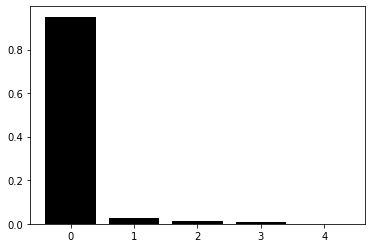

In [48]:
pca = dd.PCA(n_components = X.shape[1])
principal_components = pca.fit_transform(X)

# plot explained variable
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color = 'black')

# pca component
df_pca = pd.DataFrame(principal_components)

<AxesSubplot:xlabel='0', ylabel='1'>

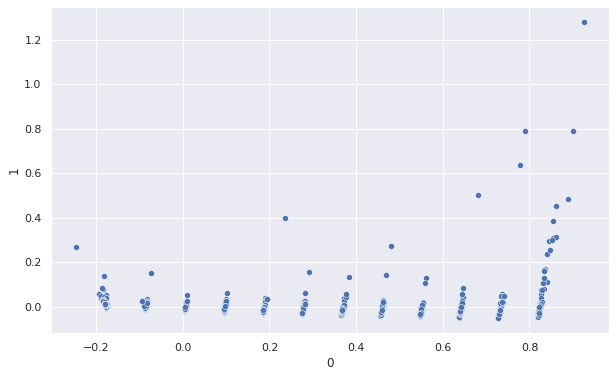

In [125]:
sns.set(rc={'figure.figsize':(10,6)})
sns.scatterplot(x=0, y=1, data = df_pca)

#### 4.2.2 UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

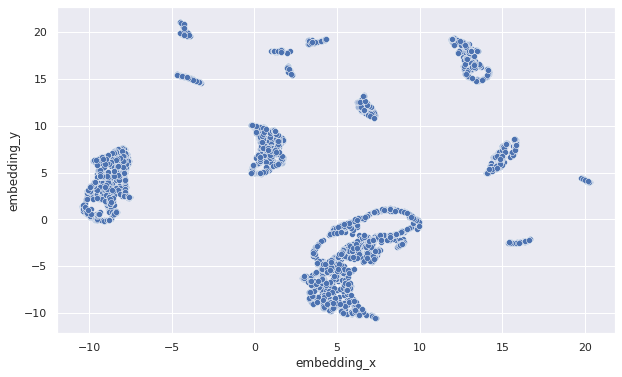

In [124]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform (X)

# embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

# plto UMAP
sns.set(rc={'figure.figsize':(10,6)})
sns.scatterplot( x='embedding_x',
                 y='embedding_y',
                 data = df_umap)

#### 4.2.3 t-SNE

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

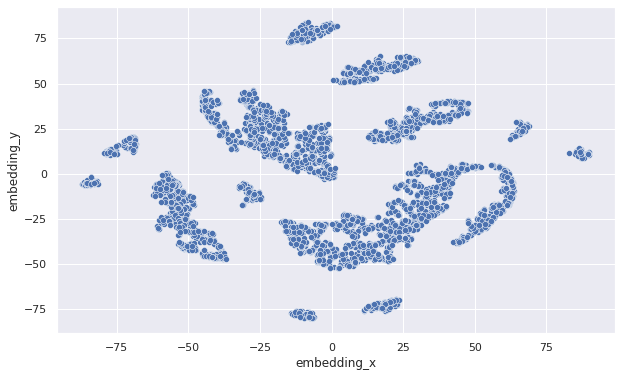

In [123]:
reducer = mn.TSNE(n_components = 2,
                  n_jobs = -1,
                  random_state=42)

embedding = reducer.fit_transform (X)

# embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

# plto UMAP
sns.set(rc={'figure.figsize':(10,6)})
sns.scatterplot( x='embedding_x',
                 y='embedding_y',
                 data = df_tsne)

#### 4.2.4 Tree-Based Embedding

In [126]:
# Training Dataset
X = df43.drop(columns=['gross_revenue'], axis=1)
y = df43['gross_revenue']

# Model Definition
rf_model = en.RandomForestRegressor(n_estimators=500, random_state=42)

# Model Training
rf_model.fit(X, y)                                                    

# Leaf
df_leaf = pd.DataFrame(rf_model.apply(X))                              

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

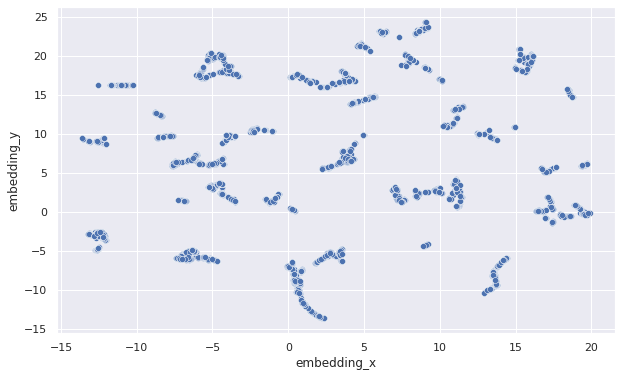

In [128]:
# Reducer Dimensionality
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform (df_leaf)

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plto UMAP
sns.set(rc={'figure.figsize':(10,6)})
sns.scatterplot( x='embedding_x',
                 y='embedding_y',
                 data = df_tree)

# 5. Hyperparameter Fine-Tunning

### 5.0 Feature Space

In [107]:
df43.head()

,gross_revenue,products_no,items_no,frequency,recorrence
0,0.019301,0.037770,0.008799,1.000000,0.000000
1,0.011567,0.021692,0.007056,0.001345,0.545455
2,0.024009,0.029476,0.025538,0.002052,0.909091
3,0.003384,0.003445,0.002225,0.000734,0.181818
4,0.003125,0.000255,0.000401,0.003985,0.090909


In [57]:
clusters = np.arange(2, 11, 1)
X = df43.copy()

In [58]:
# KMeans
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans(init='random',
                            n_clusters=k,
                            n_init=300,
                            max_iter=300,
                            random_state=42)

    # model training
    kmeans_model.fit(X)

    # clustering
    labels = kmeans_model.predict(X) 

    # model performance (SS)
    sil = m.silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil)

# GMM
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k, n_init=300)

    # model training
    gmm_model.fit(X)

    # model predict
    labels = gmm_model.predict(X)

    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    gmm_list.append(sil)

# HC
hc_list = []
for k in clusters:
    # model definition and training
    hc_model = hc.linkage(X, 'ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    hc_list.append(sil)

In [59]:
# Original Dataset Result
df_results_original = pd.DataFrame(
    {'KMeans': kmeans_list,
     'GMM': gmm_list,
     'HC': hc_list}
     ).T

df_results_original.columns = clusters
df_results_original = df_results_original.style.highlight_max(color = 'blue', axis=1)

df_results_original

,2,3,4,5,6,7,8,9,10
KMeans,0.693917,0.651845,0.702382,0.707414,0.749401,0.752663,0.811358,0.812652,0.827025
GMM,0.610487,0.388083,0.467342,0.570845,0.542578,0.602173,0.639913,0.686755,0.704598
HC,0.577335,0.625860,0.630206,0.741590,0.742478,0.748293,0.750710,0.810268,0.810678


### 5.1 Tree Based Embedding

In [60]:
# Tree Based Embedding
X = df_tree.copy()

In [61]:
# KMeans
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans(init='random',
                            n_clusters=k,
                            n_init=300,
                            max_iter=300,
                            random_state=42)

    # model training
    kmeans_model.fit(X)

    # clustering
    labels = kmeans_model.predict(X) 

    # model performance (SS)
    sil = m.silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil)

# GMM
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k, n_init=300)

    # model training
    gmm_model.fit(X)

    # model predict
    labels = gmm_model.predict(X)

    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    gmm_list.append(sil)

# HC
hc_list = []
for k in clusters:
    # model definition and training
    hc_model = hc.linkage(X, 'ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    hc_list.append(sil)

In [62]:
# Tree Based Embedding Result
df_results_tree = pd.DataFrame(
    {'KMeans': kmeans_list,
     'GMM': gmm_list,
     'HC': hc_list}
     ).T

df_results_tree.columns = clusters
df_results_tree = df_results_tree.style.highlight_max(color = 'blue', axis=1)

df_results_tree

,2,3,4,5,6,7,8,9,10
KMeans,0.372649,0.407150,0.436827,0.448516,0.465880,0.463908,0.481660,0.518283,0.527828
GMM,0.360263,0.313550,0.345297,0.412443,0.399503,0.404407,0.402359,0.490340,0.481904
HC,0.330677,0.359912,0.432107,0.414833,0.422781,0.460981,0.478889,0.510620,0.522397


### 5.2 UMAP Embedding

In [63]:
# UMAP Embedding
X = df_umap.copy()

In [64]:
# KMeans
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans(init='random',
                            n_clusters=k,
                            n_init=300,
                            max_iter=300,
                            random_state=42)

    # model training
    kmeans_model.fit(X)

    # clustering
    labels = kmeans_model.predict(X) 

    # model performance (SS)
    sil = m.silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil)

# GMM
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k, n_init=300)

    # model training
    gmm_model.fit(X)

    # model predict
    labels = gmm_model.predict(X)

    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    gmm_list.append(sil)

# HC
hc_list = []
for k in clusters:
    # model definition and training
    hc_model = hc.linkage(X, 'ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    hc_list.append(sil)

In [65]:
# UMAP Embedding Result
df_results_umap = pd.DataFrame(
    {'KMeans': kmeans_list,
     'GMM': gmm_list,
     'HC': hc_list}
     ).T

df_results_umap.columns = clusters
df_results_umap = df_results_umap.style.highlight_max(color = 'blue', axis=1)

df_results_umap

,2,3,4,5,6,7,8,9,10
KMeans,0.455992,0.554531,0.602438,0.612499,0.659798,0.624249,0.634854,0.654876,0.668884
GMM,0.455992,0.524191,0.594911,0.588137,0.576258,0.664276,0.669840,0.644133,0.653068
HC,0.390419,0.524191,0.594911,0.612499,0.640112,0.605770,0.631425,0.651522,0.666109


### 5.3 TSNE Embedding

In [66]:
# TSNE Embedding
X = df_tsne.copy()

In [67]:
# KMeans
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans(init='random',
                            n_clusters=k,
                            n_init=300,
                            max_iter=300,
                            random_state=42)

    # model training
    kmeans_model.fit(X)

    # clustering
    labels = kmeans_model.predict(X) 

    # model performance (SS)
    sil = m.silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil)

# GMM
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k, n_init=300)

    # model training
    gmm_model.fit(X)

    # model predict
    labels = gmm_model.predict(X)

    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    gmm_list.append(sil)

# HC
hc_list = []
for k in clusters:
    # model definition and training
    hc_model = hc.linkage(X, 'ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    hc_list.append(sil)

In [68]:
# TSNE Embedding Result
df_results_tsne = pd.DataFrame(
    {'KMeans': kmeans_list,
     'GMM': gmm_list,
     'HC': hc_list}
     ).T

df_results_tsne.columns = clusters
df_results_tsne = df_results_tsne.style.highlight_max(color = 'blue', axis=1)

### 5.4 Summarize Results

In [69]:
# Original Feature Space
df_results_original

,2,3,4,5,6,7,8,9,10
KMeans,0.693917,0.651845,0.702382,0.707414,0.749401,0.752663,0.811358,0.812652,0.827025
GMM,0.610487,0.388083,0.467342,0.570845,0.542578,0.602173,0.639913,0.686755,0.704598
HC,0.577335,0.625860,0.630206,0.741590,0.742478,0.748293,0.750710,0.810268,0.810678


In [70]:
# TSNE Embedding Results
df_results_tsne

,2,3,4,5,6,7,8,9,10
KMeans,0.374658,0.416384,0.423753,0.462701,0.478199,0.467292,0.460277,0.454908,0.470793
GMM,0.366015,0.367674,0.386914,0.362438,0.352315,0.356056,0.414840,0.340620,0.352017
HC,0.334897,0.381340,0.407158,0.440055,0.470800,0.472001,0.472386,0.476787,0.464592


In [71]:
# Tree Based Embedding Results
df_results_tree

,2,3,4,5,6,7,8,9,10
KMeans,0.372649,0.407150,0.436827,0.448516,0.465880,0.463908,0.481660,0.518283,0.527828
GMM,0.360263,0.313550,0.345297,0.412443,0.399503,0.404407,0.402359,0.490340,0.481904
HC,0.330677,0.359912,0.432107,0.414833,0.422781,0.460981,0.478889,0.510620,0.522397


In [72]:
# UMAP Embedding Results
df_results_umap

,2,3,4,5,6,7,8,9,10
KMeans,0.455992,0.554531,0.602438,0.612499,0.659798,0.624249,0.634854,0.654876,0.668884
GMM,0.455992,0.524191,0.594911,0.588137,0.576258,0.664276,0.669840,0.644133,0.653068
HC,0.390419,0.524191,0.594911,0.612499,0.640112,0.605770,0.631425,0.651522,0.666109


# 6. Machine Learning Modelling

In [93]:
# Selecting the best embedding
X = df43.copy()

### 6.1 K-Means

In [94]:
# model definition
k=6
kmeans = c.KMeans(init='random',
                  n_clusters=k,
                  n_init=300,
                  max_iter=300,
                  random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

In [95]:
# k=7
# # model definition
# gmm_model = mx.GaussianMixture(n_components=k, n_init = 300, random_state=42)

# # model training
# gmm_model.fit(X)

# # clustering
# labels = gmm_model.predict(X)

### 6.2 Cluster Validation

In [96]:
# # WSS
# print(f'WSS Value:{kmeans.inertia_}')

# SS
print('SS Value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

SS Value: 0.749401061479475


# 7. Evaluation - Cluster Analysis

### 7.1 Visualization Inspection

In [97]:
df9 = X.copy()
df9['cluster'] = labels
df9.head()



,gross_revenue,products_no,items_no,frequency,recorrence,cluster
0,0.019301,0.037770,0.008799,1.000000,0.000000,5
1,0.011567,0.021692,0.007056,0.001345,0.545455,0
2,0.024009,0.029476,0.025538,0.002052,0.909091,2
3,0.003384,0.003445,0.002225,0.000734,0.181818,3
4,0.003125,0.000255,0.000401,0.003985,0.090909,4


In [98]:
# sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep')

### 7.2 Cluster Profile

In [99]:
df92 = df4.copy()
df92['cluster'] = labels

# Change dtypes
df92['recency_days']    = df92['recency_days'].astype(int)
df92['purchases_no']    = df92['purchases_no'].astype(int)
df92['products_no']     = df92['products_no'].astype(int)
df92['items_no']        = df92['items_no'].astype(int)

In [100]:
df92.head()

,customer_id,gross_revenue,recency_days,purchases_no,products_no,items_no,frequency,returns_no,satisfaction_rate,recorrence,cluster
0,17850,5391.21,372,34,297,1733,17.000000,40.0,0.976919,1.0,5
1,13047,3232.59,56,9,171,1390,0.028302,35.0,0.974820,7.0,0
2,12583,6705.38,2,15,232,5028,0.040323,50.0,0.990056,11.0,2
3,13748,948.25,95,5,28,439,0.017921,0.0,1.000000,3.0,3
4,15100,876.00,333,3,3,80,0.073171,22.0,0.725000,2.0,4


In [101]:
# Number of customer
df_cluster = df92[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = (df_cluster['customer_id'] / df_cluster['customer_id'].sum())*100

# Avg gross revenue
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on = 'cluster')

# Avg purchases_no
df_avg_purchases_no = df92[['purchases_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_purchases_no, how='inner', on='cluster')

# Avg products_no
df_avg_products_no = df92[['products_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_products_no, how='inner', on='cluster')

# Avg items_no
df_avg_items_no = df92[['items_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_items_no, how='inner', on='cluster')

# Avg frequency
df_avg_frequency = df92[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_frequency, how='inner', on='cluster')

# Avg recorrence
df_recorrence = df92[['recorrence', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_recorrence, how='inner', on='cluster')


In [102]:
df_cluster.sort_values('gross_revenue', ascending=False)

,cluster,customer_id,perc_customer,gross_revenue,purchases_no,products_no,items_no,frequency,recorrence
2,2,162,3.750868,19509.810864,28.882716,558.006173,10972.228395,0.081103,11.018519
0,0,263,6.089373,4862.485779,11.517110,238.045627,3046.779468,0.037414,7.885932
1,1,430,9.956008,2836.961326,6.934884,164.525581,1634.597674,0.027310,5.383721
3,3,915,21.185460,1525.778459,4.109290,93.321311,936.793443,0.025535,3.424044
4,4,918,21.254920,833.931373,2.298475,51.145969,499.606754,0.037875,2.000000
5,5,1631,37.763371,425.130681,1.126303,24.630901,245.707541,1.009846,1.000613


- 1° (5): Insiders
- 2° (6): Pre-Insider - aumentar qtde de produtos comprados (cross sell), aumentar a frequencia (cupom de desconto)
- 3° (1): Cluster Even More Products
- 4° (0): Cluster Spend Money
- 5° (2): Improve Recency
- 6° (4): Less then 1K
- 7° (3): More then 3 months

### 7.3 Cluster Analysis

#### 7.3.1 Mindmap

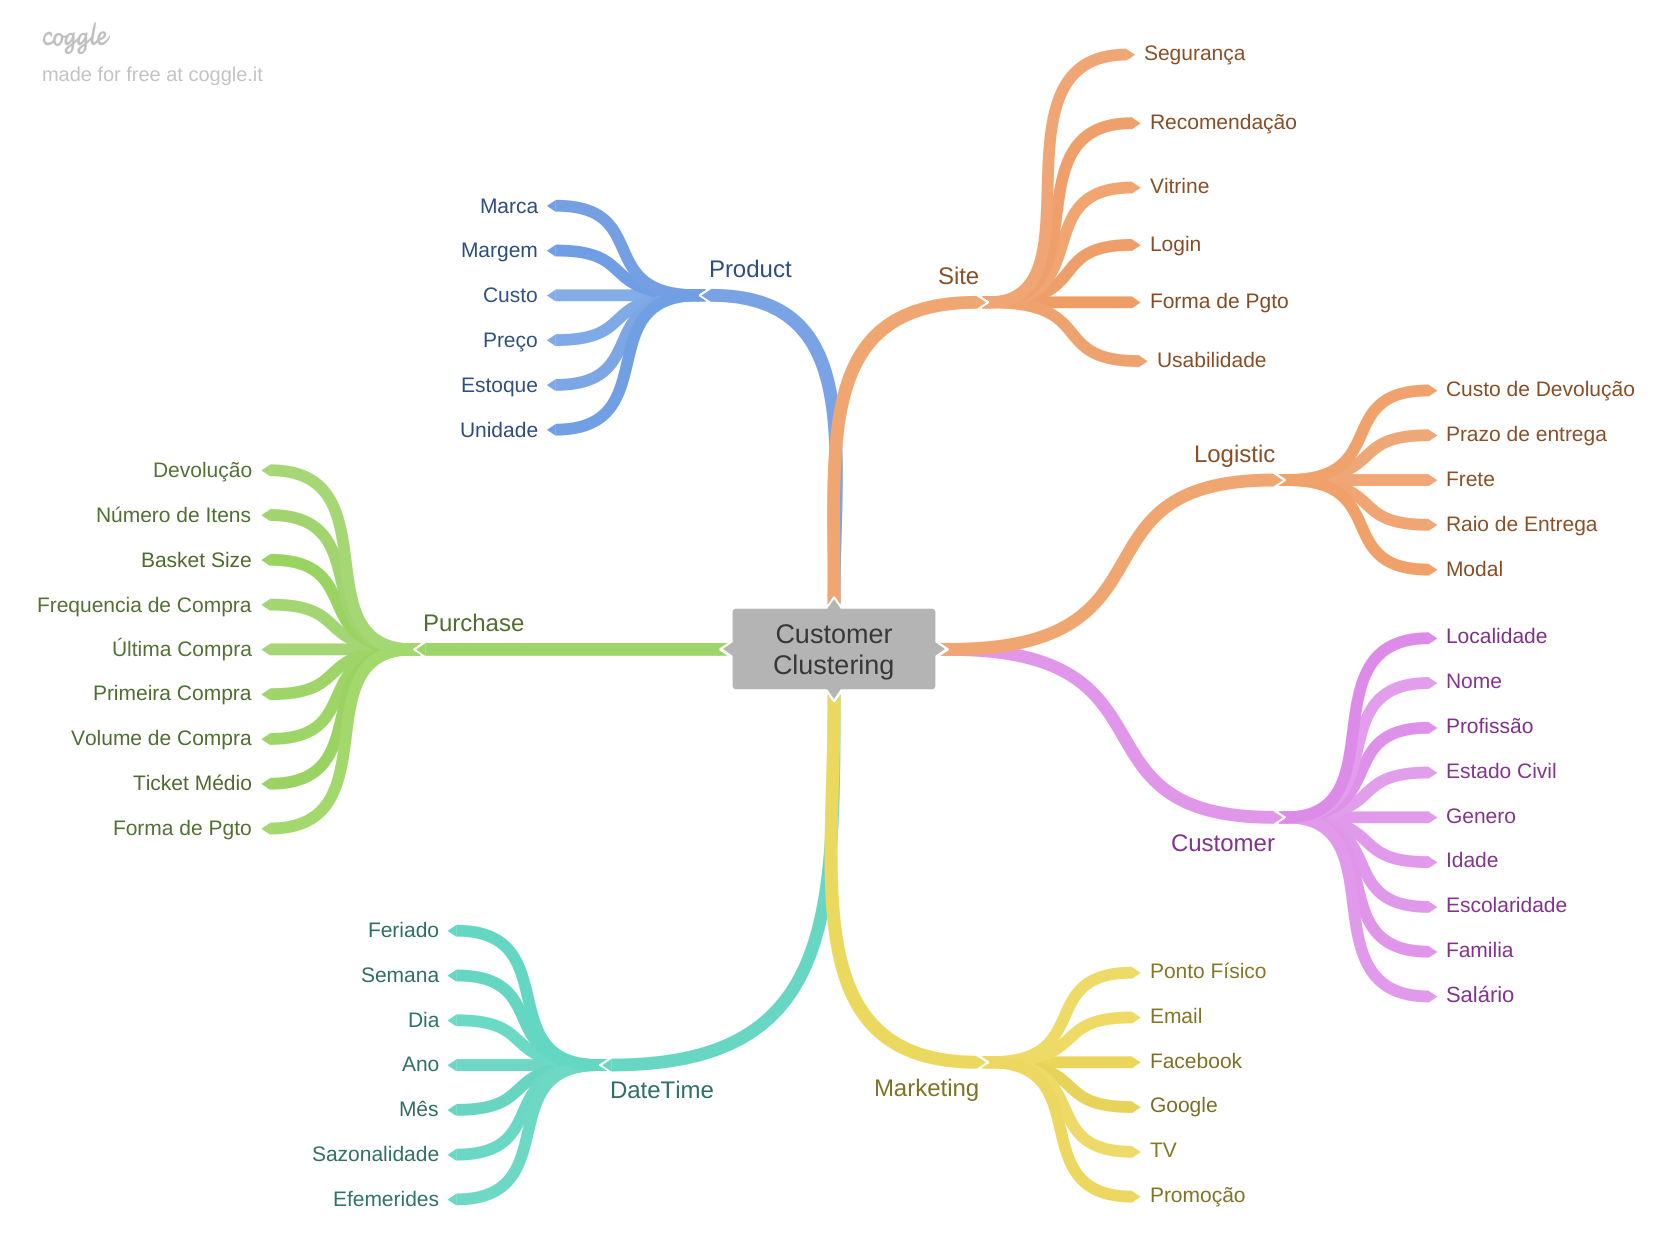

In [449]:
Image('../image/mind_map.png', width=800)

#### 7.3.2 Business Hypothesis

##### Hipoteses de Compras

1. Os clientes do cluster insiders usam cartão de crédito em  80% das compras;                                  --> *Não tem informações para validar essa analise*
3. Os clientes do cluster insiders possuem um basket size acima de 5 produtos;                                  --> *Não tem informações para validar essa analise*
3. Os clientes do cluster insiders possuem um faturamento acima de 10% do total de compras                      --> **Analisar**    
4. Os clientes do cluster insiders possuem um valor de compra acima de 10% do total de compras                  --> **Analisar**
5. Os clientes do cluster insiders possuem um número de devolução abaixo da média da base total de clientes.    --> **Analisar**

##### Hipoteses de Clientes

1. 60% dos clientes do cluster insiders são solteiros;                                              --> *Não tem informações para validar essa analise* 
2. 10% dos clientes do cluster insiders estão na faixa de 24 a 35 anos;                             --> *Não tem informações para validar essa analise*
3. 40% das localidades de entrega do cluster insiders estão dentro de um raio de 50km;              --> *Não tem informações para validar essa analise*
4. 5% dos clientes do cluster insiders recebem mais de 100 mil dolares anualmente;                  --> *Não tem informações para validar essa analise*
5. 90% dos clientes do cluster insiders tem ensino superior completo;                               --> *Não tem informações para validar essa analise*

##### Hipoteses de Produtos

1. 30% dos produtos em pacotes grandes são comprados pelos clientes do cluster insiders; --> *Não tem informações para validar essa analise* 
2. A mediana dos faturamento do grupo Insiders é 10% maior que de toda base; --> **Analisar**
3. O percentil do GMV pelos clientes Insiders; --> **Analisar** 
4. O peso médio dos produtos comprados pelo Insiders é maior que o pedo médio do restante da base; --> *Não tem informações para validar essa analise* 
5. A idade média dos produtos comprados pelos clientes do cluster insiders é menor que 15 dias; --> *Não tem informações para validar essa analise* 

#### 7.3.3 Hypothesis Analysis

##### Dataset

In [103]:
df10 = df92.copy()
df10.head()

,customer_id,gross_revenue,recency_days,purchases_no,products_no,items_no,frequency,returns_no,satisfaction_rate,recorrence,cluster
0,17850,5391.21,372,34,297,1733,17.000000,40.0,0.976919,1.0,5
1,13047,3232.59,56,9,171,1390,0.028302,35.0,0.974820,7.0,0
2,12583,6705.38,2,15,232,5028,0.040323,50.0,0.990056,11.0,2
3,13748,948.25,95,5,28,439,0.017921,0.0,1.000000,3.0,3
4,15100,876.00,333,3,3,80,0.073171,22.0,0.725000,2.0,4


##### H1. Os clientes do cluster insiders possuem um faturamento acima de 10% do total de compras. **True** 


In [105]:
df_gmv_insiders = df10.loc[df10['cluster'] == 2, 'gross_revenue'].sum()
df_gmv_total = df10.loc[:, 'gross_revenue'].sum()

# Insiders rate
print(f'% Gross Revenue Insiders: {df_gmv_insiders / df_gmv_total:.2%}')


% Gross Revenue Insiders: 37.12%


##### H2. Os clientes do cluster insiders possuem um volume de compra (produtos) acima de 10% do total de compras. **True**

In [106]:
df_sales_insiders = df10.loc[df10['cluster'] == 2, 'items_no'].sum()
df_sales_total = df10.loc[:, 'items_no'].sum()

# Insiders rate
print(f'% Sales Insiders: {df_sales_insiders / df_sales_total:.2%}')


% Sales Insiders: 35.56%


##### H3. Os clientes do cluster insiders possuem uma taxa de devolução média abaixo da base total de clientes. **False**

In [108]:
# media de devolução do cluester Insiders
df_avg_returns_insiders = df10.loc[df10['cluster']==2, 'returns_no'].mean()
df_avg_products_insiders = df10.loc[df10['cluster']==2, 'items_no'].mean()
return_rate_insiders = df_avg_returns_insiders / df_avg_products_insiders

# media de devolução do total da base
df_avg_returns_total = df10.loc[:, 'returns_no'].mean()
df_avg_products_total = df10.loc[:, 'items_no'].mean()
return_rate_total = df_avg_returns_total / df_avg_products_total

print(f'Return Rate Insiders: {return_rate_insiders:.2%} vs Return Rate Total: {return_rate_total:.2%}')


Return Rate Insiders: 2.17% vs Return Rate Total: 1.98%


##### H4. A mediana do faturamento do grupo Insiders é 10% maior que de toda base. **True**


In [109]:
# mediana de GMV do insiders

df_median_gmv_insiders = df10.loc[df10['cluster']==5, 'gross_revenue'].median()
df_median_gmv_total = df10.loc[:, 'gross_revenue'].median()

gmv_diff = (df_median_gmv_insiders - df_median_gmv_total) / df_median_gmv_total

print(f'Median Diff:{gmv_diff:.1%}')


Median Diff:-58.1%


##### H5. O GMV dos clientes Insiders estão concentrados no terceiro quartil. **False**

In [112]:
np.percentile(df10.loc[df10['cluster']==2, 'gross_revenue'], q=0.1)

1334.97213

In [113]:
np.percentile(df10.loc[df10['cluster']==2, 'gross_revenue'], q=0.9)


1607.56061

<AxesSubplot:xlabel='gross_revenue'>

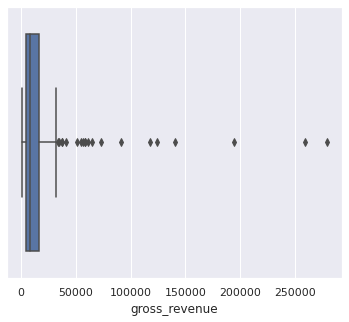

In [114]:
sns.boxplot(df10.loc[df10['cluster']==2, 'gross_revenue'])

<AxesSubplot:xlabel='gross_revenue'>

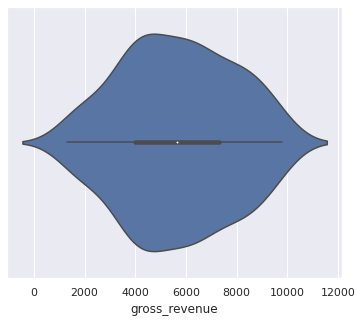

In [115]:
# "Zoom" no boxplot
df_aux = df10.loc[(df10['cluster']==2) & (df10['gross_revenue']<10000), 'gross_revenue']
sns.violinplot(x=df_aux)


#### 7.3.4 Perguntas de Negócios

##### Q1: Quem são as pessoas elegíveis para participar do programa de Insiders ?

In [117]:
df10.loc[df10['cluster']==2, 'customer_id'].head()

2     12583
6     14688
8     15311
12    16029
15    17511
Name: customer_id, dtype: int64

##### Q2: Quantos clientes farão parte do grupo?

In [116]:
df10.loc[df10['cluster']==2, 'customer_id'].size


162

##### Q3: Quais as principais características desses clientes ?

- Avg Revenue: $8,859.36
- Avg Recency: 21 days
- Avg of products purchased: 425 products
- Frequency: 0,09 purchase/day

##### Q4: Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?

In [119]:
df_gmv_insiders = df10.loc[df10['cluster'] == 2, 'gross_revenue'].sum()
df_gmv_total = df10.loc[:, 'gross_revenue'].sum()

# Insiders rate
print(f'% Gross Revenue Insiders: {df_gmv_insiders / df_gmv_total:.2%}')

% Gross Revenue Insiders: 37.12%


##### Q5: Qual a expectativa de faturamento desse grupo para os próximos meses ?

##### Q6: Quais as condições para uma pessoa ser elegível ao Insiders ?

O modelo irá definir quem está apto a entrar no Insiders

##### Q7: Quais as condições para uma pessoa ser removida do Insiders ?

O modelo irá definir quem vai sair do Insiders

##### Q8: Qual a garantia que o programa Insiders é melhor que o restante da base ?

In [120]:
df_cluster.sort_values('gross_revenue', ascending=False)

,cluster,customer_id,perc_customer,gross_revenue,purchases_no,products_no,items_no,frequency,recorrence
2,2,162,3.750868,19509.810864,28.882716,558.006173,10972.228395,0.081103,11.018519
0,0,263,6.089373,4862.485779,11.517110,238.045627,3046.779468,0.037414,7.885932
1,1,430,9.956008,2836.961326,6.934884,164.525581,1634.597674,0.027310,5.383721
3,3,915,21.185460,1525.778459,4.109290,93.321311,936.793443,0.025535,3.424044
4,4,918,21.254920,833.931373,2.298475,51.145969,499.606754,0.037875,2.000000
5,5,1631,37.763371,425.130681,1.126303,24.630901,245.707541,1.009846,1.000613


##### Q9: Quais ações o time de marketing pode realizar para aumentar o faturamento?

Ações que vão impactar o faturamento:
- Ações de Cross Sell para aumentar a quantidade de produtos comprados
- Açoes promocionais como cupom de desconto para aumentar a frequencia de compra